In [1]:
#pip install lightfm

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
#from implicit.als import AlternatingLeastSquares
#from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from src.metrics import precision_at_k as precision_at_k_
#from src.metrics import recall_at_k as recall_at_k_
#from src.utils import prefilter_items

In [56]:
import lightfm.evaluation
pr = lightfm.evaluation.precision_at_k

In [57]:
data = pd.read_csv('K:/2020/Programming/Data Science/Рекомендательные системы/Урок 3/test/retail_train.csv')
item_features = pd.read_csv('K:/2020/Programming/Data Science/Рекомендательные системы/Урок 3/test/product.csv')
user_features = pd.read_csv('K:/2020/Programming/Data Science/Рекомендательные системы/Урок 3/test/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [58]:
# проверим взаимосвязь стоимостного объема продаж sales_value с порядковыми недельными данными week_no
# видим, что в последние недели стоимостной объем продаж резко упал

(array([ 14.,  76., 147., 133., 107., 123., 242., 296., 168., 141.]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

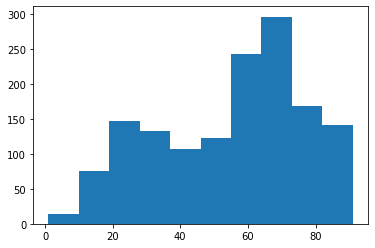

In [59]:
plt.hist(data_train.loc[data_train['sales_value']>50, 'week_no'])

In [60]:
# проверим натуральный объем продаж по неделям в штуках товара quantity
# видим, что в натуральном выражении объем продаж также упал в последние недели

(array([ 310., 1594., 2448., 2208., 2078., 2216., 2382., 2461., 2472.,
        2339.]),
 array([ 2. , 10.9, 19.8, 28.7, 37.6, 46.5, 55.4, 64.3, 73.2, 82.1, 91. ]),
 <BarContainer object of 10 artists>)

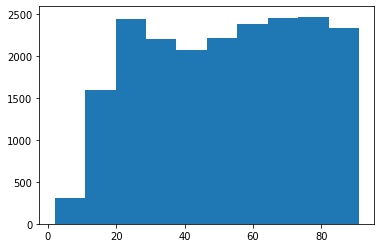

In [61]:
plt.hist(data_train.loc[data_train['quantity']>50, 'week_no'])

In [62]:
# проверим стоимостную динамику продаж в последние три недели
# видим, что стоимостная динамика продаж в последние три недели заметно выросла

(array([41.,  0.,  0., 14.,  0.,  0., 11.,  0.,  0.,  8.]),
 array([92. , 92.3, 92.6, 92.9, 93.2, 93.5, 93.8, 94.1, 94.4, 94.7, 95. ]),
 <BarContainer object of 10 artists>)

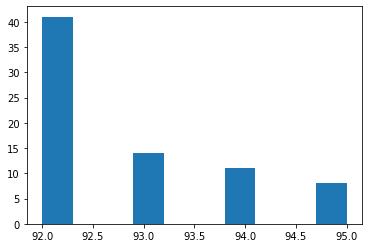

In [63]:
plt.hist(data_test.loc[data_test['sales_value']>50, 'week_no'])

In [64]:
# проверим динамику натурального объема продаж в последние три недели
# видим, что динамика продаж товара в натуральном выражении также немного выросла в последние три недели

(array([262.,   0.,   0., 191.,   0.,   0., 262.,   0.,   0., 239.]),
 array([92. , 92.3, 92.6, 92.9, 93.2, 93.5, 93.8, 94.1, 94.4, 94.7, 95. ]),
 <BarContainer object of 10 artists>)

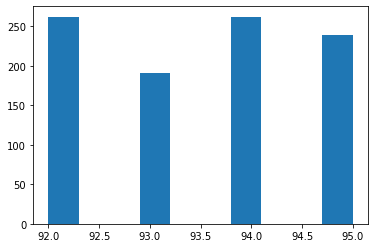

In [65]:
plt.hist(data_test.loc[data_test['quantity']>50, 'week_no'])

In [66]:
# можно сделать вывод, что в последние три недели был изменен подход предприятия к продажам,
# скорее всего, поменяли ассортиментную и ценовую политику - стали продавать больше товара более высокой ценовой категории, который больше востребован покупателями,
# либо поменяли целевую аудиторию для маркетинга (например, выбрали более молодую аудиторию)

In [67]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [68]:
item_features['department'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [69]:
item_features['commodity_desc'].unique()

array(['FRZN ICE', 'NO COMMODITY DESCRIPTION', 'BREAD',
       'FRUIT - SHELF STABLE', 'COOKIES/CONES', 'SPICES & EXTRACTS',
       'VITAMINS', 'BREAKFAST SWEETS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'MAGAZINE', 'AIR CARE', 'CHEESE',
       'SHORTENING/OIL', 'COFFEE', 'DIETARY AID PRODUCTS',
       'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'DINNER SAUSAGE', 'FRZN FRUITS', 'SEAFOOD - FROZEN',
       'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'CAKES',
       'BAKING MIXES', 'POTATOES', 'FLUID MILK PRODUCTS', 'SOUP',
       'BAKED SWEET GOODS', 'COOKIES', 'DRY BN/VEG/POTATO/RICE',
       'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA', 'EGGS',
       'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'POPCORN',
   

In [70]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [71]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [72]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [73]:
user_features['hh_comp_desc'].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [74]:
#n_items_before = data_train['item_id'].nunique()

#data_train = prefilter_items(data_train)

#n_items_after = data_train['item_id'].nunique()
#print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

In [75]:
#data_test = prefilter_items(data_test)

In [76]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
# filter non top-5000
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float)
sparse_user_item_test = csr_matrix(test_user_item_matrix).tocsr()

In [78]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [79]:
user_item_matrix.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500],
           dtype='int64', name='user_id', length=2499)

In [80]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [81]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
user_feat['age_desc'].unique()

array(['65+', nan, '45-54', '25-34', '35-44', '19-24', '55-64'],
      dtype=object)

In [83]:
user_feat['marital_status_code'].unique()

array(['A', nan, 'U', 'B'], dtype=object)

In [84]:
user_feat['hh_comp_desc'].unique()

array(['2 Adults No Kids', nan, '2 Adults Kids', 'Single Female',
       'Unknown', 'Single Male', '1 Adult Kids'], dtype=object)

In [85]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [86]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
item_feat_lightfm.head()

,manufacturer_2.0,manufacturer_5.0,manufacturer_10.0,manufacturer_16.0,manufacturer_35.0,manufacturer_36.0,manufacturer_42.0,manufacturer_43.0,manufacturer_58.0,manufacturer_61.0,...,curr_size_of_product_L 5.5OZ,curr_size_of_product_L .15 OZ,curr_size_of_product_L 7.75 OZ,curr_size_of_product_L 13.25 OZ,curr_size_of_product_LTR,curr_size_of_product_N 12 OZ,curr_size_of_product_N 5.4 OZ,curr_size_of_product_PINT,curr_size_of_product_PK,curr_size_of_product_PT
item_id,,,,,,,,,,,,,,,,,,,,,
202291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
480014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
model = LightFM(no_components=10,
                loss='warp', # 'bpr'
                learning_rate=0.05, 
                item_alpha=0.1, # смещение по товару
                user_alpha=0.1, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15) 

In [89]:
user_biases_emb = model.get_user_representations(
    features=csr_matrix(user_feat_lightfm.values).tocsr()
)

In [90]:
item_biases_emb = model.get_item_representations(
    features=csr_matrix(item_feat_lightfm.values).tocsr()
)

In [91]:
len(user_biases_emb)

2

In [92]:
user_biases_emb[0].shape

(2499,)

In [93]:
user_biases_emb[1].shape

(2499, 10)

In [94]:
item_biases_emb[1].shape

(5001, 10)

In [95]:
item_biases_emb[0].shape

(5001,)

In [96]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [97]:
train_precision

0.5168468

In [98]:
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [99]:
test_precision

0.0034447822

In [100]:
test_item_ids = np.arange(len(itemids))

predictions = model.predict(user_ids=6, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [101]:
test_item_ids

array([   0,    1,    2, ..., 4998, 4999, 5000])

In [102]:
np.sort(predictions)[::-1]

array([-15.010796, -15.012898, -15.037516, ..., -15.578215, -15.578215,
       -15.586188], dtype=float32)

In [103]:
  
    #time_t = []
    
    
    for components in [5, 7, 10, 12, 15]:
        
        model = LightFM(no_components=components,
                loss='warp', # 'bpr'
                learning_rate=0.05, 
                item_alpha=0.1, # смещение по товару
                user_alpha=0.1, 
                random_state=42)

        model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                 sample_weight=coo_matrix(user_item_matrix),
                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                 epochs=15) 
        
        train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
        test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
        print(f"train_precision {train_precision}")
        
        print(f"test_precision {test_precision}")
        
    
        #print(%%time)
        
        #start_time = datetime.now()
        
        #time.sleep(5)
        
        #time_ = (datetime.now() - start_time).microseconds/1000
        
        #time_t.append(time_)
        
        #print(time_t)       

train_precision 0.45562222599983215
test_precision 0.0033434650395065546
train_precision 0.43993598222732544
test_precision 0.002735562389716506
train_precision 0.516846776008606
test_precision 0.0034447822254151106
train_precision 0.5335735082626343
test_precision 0.003242147620767355
train_precision 0.516846776008606
test_precision 0.0034447822254151106


In [104]:
for i_alpha in [0.01, 0.05, 0.1, 0.15, 0.2]:
    #for u_alpha in [0.01, 0.03, 0.05, 12, 15]:
        
        model = LightFM(no_components=15,
                loss='warp', # 'bpr'
                learning_rate=0.05, 
                item_alpha=i_alpha, # смещение по товару
                user_alpha=0.1, 
                random_state=42)

        model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                 sample_weight=coo_matrix(user_item_matrix),
                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                 epochs=15) 
        
        train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
        test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
        print(f"train_precision {train_precision}")
        
        print(f"test_precision {test_precision}")

train_precision 0.5335735082626343
test_precision 0.003242147620767355
train_precision 0.5232493281364441
test_precision 0.0033434652723371983
train_precision 0.516846776008606
test_precision 0.0034447822254151106
train_precision 0.438895583152771
test_precision 0.003546099178493023
train_precision 0.438895583152771
test_precision 0.003546099178493023


In [105]:
#for i_alpha in [0.01, 0.05, 0.1, 0.15, 0.2]:
for u_alpha in [0.01, 0.03, 0.05, 12, 15]:
        
        model = LightFM(no_components=15,
                loss='warp', # 'bpr'
                learning_rate=0.05, 
                item_alpha=0.15, # смещение по товару
                user_alpha=u_alpha, 
                random_state=42)

        model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                 sample_weight=coo_matrix(user_item_matrix),
                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                 epochs=15) 
        
        train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
        test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
        print(f"train_precision {train_precision}")
        
        print(f"test_precision {test_precision}")

train_precision 0.36830732226371765
test_precision 0.0021276595070958138
train_precision 0.4479391872882843
test_precision 0.002532928017899394
train_precision 0.4918767213821411
test_precision 0.0034447822254151106
train_precision 0.3375750482082367
test_precision 0.0024316110648214817
train_precision 0.3766306936740875
test_precision 0.002836879575625062


In [106]:
#for i_alpha in [0.01, 0.05, 0.1, 0.15, 0.2]:
#for u_alpha in [0.01, 0.03, 0.05, 12, 15]:
        
model = LightFM(no_components=15,
                loss='bpr', # 'bpr'
                learning_rate=0.05, 
                item_alpha=0.15, # смещение по товару
                user_alpha=0.05, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                 sample_weight=coo_matrix(user_item_matrix),
                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                 epochs=15) 

In [107]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
        
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [108]:
print(f"train_precision {train_precision}")

train_precision 0.23729494214057922


In [109]:
print(f"test_precision {test_precision}")

test_precision 0.005572441965341568


In [110]:
# подобраны параметры, дающие максимальное precision на тесте: no_components = 15, loss = bpr, item_alpha = 0,15, user_alpha = 0,05
# precision при этои увеличилось незначительно

In [111]:
# теперь удалим commodity_desc и sub_commodity_desc фичи из данных по items

In [112]:
item_features = item_features.drop(columns=['commodity_desc', 'sub_commodity_desc'], axis=1)

In [113]:
item_features.head(2)

,item_id,manufacturer,department,brand,curr_size_of_product
0,25671,2,GROCERY,National,22 LB
1,26081,2,MISC. TRANS.,National,


In [114]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
# filter non top-5000
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float)
sparse_user_item_test = csr_matrix(test_user_item_matrix).tocsr()

In [116]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [117]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [119]:
# возьмем первоначальную модель с уменьшенным количеством фичей в item

In [120]:
model = LightFM(no_components=10,
                loss='warp', # 'bpr'
                learning_rate=0.05, 
                item_alpha=0.1, # смещение по товару
                user_alpha=0.1, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15) 

In [121]:
user_biases_emb = model.get_user_representations(
    features=csr_matrix(user_feat_lightfm.values).tocsr()
)

In [122]:
item_biases_emb = model.get_item_representations(
    features=csr_matrix(item_feat_lightfm.values).tocsr()
)

In [123]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [124]:
train_precision

0.36838737

In [125]:
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [126]:
test_precision

0.0045592706

In [127]:
# видим незначительный прирост precision на тесте за счет убавления фичей со множественными параметрами в items

In [128]:
# прогоним модель с ранее подобранными гиперпараметрами для датасета с убавленными фичами по items

In [129]:
model = LightFM(no_components=15,
                loss='bpr', # 'bpr'
                learning_rate=0.05, 
                item_alpha=0.15, # смещение по товару
                user_alpha=0.05, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15) 

In [130]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [131]:
train_precision

0.230012

In [132]:
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [133]:
test_precision

0.0031408307

In [134]:
# precision на тесте с убавлением фичей оказывается выше при сохранении старых гиперпараметров, 
# нежели чем с применением ранее подобранных гиперпараметров
# есть смысл убавлять избыточные фичи и улучшать точность посредством перебора гиперпараметров, хотя перебор 
# получается весьма времязатратным даже с убавлением избыточных фичей
